In [1]:
from ipywidgets import widgets, interact
import os
import random
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import time
import glob

In [2]:
user = 'chris'

In [3]:
%%javascript
var kernel = IPython.notebook.kernel;
var command = ["currenturl = ", "'", window.location.href, "'" ].join('')
kernel.execute(command)

<IPython.core.display.Javascript object>

In [4]:
from urllib.parse import urlparse
o = urlparse(currenturl)
hostname = o.hostname

In [5]:
cifarpath = os.path.join('cifar-10', "*.bin")
size           = 32
color_channels = 3
image_size     = size * size * color_channels
label_size     = 1
raw_size       = image_size + label_size
inputraw       = []
labelsraw      = []
for cifarbinname in glob.glob(cifarpath):
    with open(cifarbinname, 'rb') as cifarfile:
        raw = cifarfile.read()
        n_images = len(raw) // raw_size
        offset = 0
        for i in range(n_images):
            single = np.frombuffer(raw, dtype=np.uint8, count=image_size, offset=offset + label_size)
            labelsraw.append(raw[offset])
            inputraw.append(single)
            offset += raw_size
print("TOTAL {} images".format(len(inputraw)))
images_ = np.stack(inputraw, axis = 0).reshape([-1, color_channels, size, size])
labels_ = np.array(labelsraw, dtype=np.int32)
with open(os.path.join('cifar-10', 'batches.meta.txt'), 'r') as metafile:
    lines = metafile.readlines();
label_text = [x.strip() for x in lines]
nlabels = len(label_text)
nimages = images_.shape[0]

TOTAL 60000 images


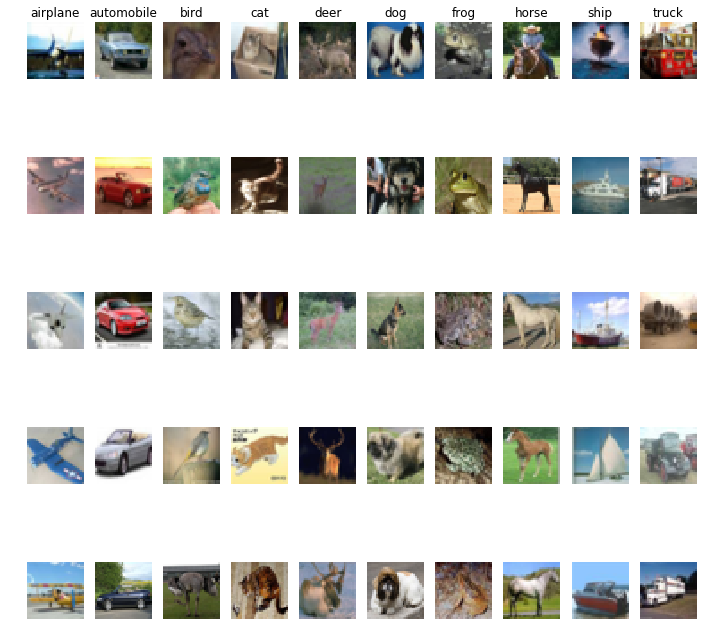

In [6]:
images_reshaped = images_.transpose([0,2,3,1])
sort_index = np.argsort(labels_)
images_sorted = images_reshaped[sort_index]
labels_sorted = labels_[sort_index]
plt.figure(figsize=(12,12))
images_per_category = nimages // nlabels

samples = 5
for i in range(nlabels):
    for j in range(samples):
        index = random.randint(0, images_per_category - 1)
        plt.subplot(samples, nlabels, j * nlabels + i + 1)
        plt.axis('off')
        plt.xlabel("")
        plt.ylabel("")
        plt.imshow(images_sorted[i * images_per_category + index], interpolation='nearest')
        if (j == 0):
            plt.title(label_text[labels_sorted[i * images_per_category + index]])
plt.show()

In [7]:
def display_images_and_labels(images, labels, numbers):
    plt.figure(figsize=(12,12))
    x = list(range(labels.size))
    random.shuffle(x)
    img_ = images[x]
    lbl_ = labels[x]
    for i in range(numbers):
        plt.subplot(numbers, 1, i + 1)
        plt.axis('off')
        plt.xlabel("")
        plt.ylabel("")
        plt.imshow(img_[i], interpolation='nearest')
        plt.title(label_text[lbl_[i]])
plt.show()

In [8]:
def shuffle_images(images, labels):
    x = list(range(images_reshaped.shape[0]))
    random.shuffle(x)
    return images_reshaped[x], labels[x]
images, labels = shuffle_images(images_reshaped, labels_)

In [9]:
train2test_ratio = 6
test_size  = images.shape[0] // train2test_ratio
train_size = nimages - test_size
train_images, test_images = np.split(images, [train_size])
train_labels, test_labels = np.split(labels, [train_size])
print("train_images shape = {} train_labels shape = {} test_images shape = {} test_labels shape = {}".format(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape))

train_images shape = (50000, 32, 32, 3) train_labels shape = (50000,) test_images shape = (10000, 32, 32, 3) test_labels shape = (10000,)


In [10]:
from IPython.display import display, HTML
url = "<iframe src=http://" + hostname + ":8080/?user=" + user + " width=700 height=500></iframe>"
HTML(url)

In [11]:
modelfile = os.path.join('model', user + '.py')

In [12]:
# %load model/chris.py
def model(net):

    net = tf.contrib.layers.conv2d(net, 64, [5,5], 1, activation_fn = tf.nn.relu, padding='SAME', scope='conv2')

    net = tf.contrib.layers.max_pool2d(net, [3, 3], 2, padding='SAME', scope='pool3')

    net = tf.nn.lrn(net, 4, bias = 1.00, alpha = 0.001/9.0, beta = 0.750, name = 'lrn4')

    net = tf.contrib.layers.conv2d(net, 64, [5,5], 1, activation_fn = tf.nn.relu, padding='SAME', scope='conv5')

    net = tf.nn.lrn(net, 4, bias = 1.00, alpha = 0.001/9.0, beta = 0.750, name = 'lrn6')

    net = tf.contrib.layers.max_pool2d(net, [3, 3], 2, padding='SAME', scope='pool7')

    net = tf.contrib.layers.flatten(net, scope='flatten8')
    net = tf.contrib.layers.fully_connected(net, 384, activation_fn=tf.nn.relu, scope='fc9')

    net = tf.contrib.layers.fully_connected(net, 192, activation_fn=tf.nn.relu, scope='fc10')

    net = tf.contrib.layers.fully_connected(net, 10, activation_fn=None, scope='fc11')
    return net


In [13]:
class Network:
    def __init__(self):
        self.input = tf.placeholder(dtype = tf.int32, shape = [None, size, size, color_channels], name = "input")
        self.label = tf.placeholder(dtype = tf.int32, shape = [None], name = "label")
        self.image = tf.placeholder(dtype = tf.int32, shape = [size, size, color_channels])
        image = tf.cast(self.image, tf.float32)
        self.standadize = tf.image.per_image_standardization(image)
        self.randomize = tf.image.random_flip_left_right(image)
        self.randomize = tf.image.random_brightness(self.randomize, max_delta = 63)
        self.randomize = tf.image.random_contrast(self.randomize, lower=0.2, upper=1.8)
        self.randomize = tf.image.per_image_standardization(self.randomize)
        input_converted = tf.cast(self.input, tf.float32)
        self.logits = model(input_converted)
        self.probability = tf.nn.softmax(self.logits, name = "probability")
        losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = self.label, logits = self.logits, name = 'losses')
        self.loss = tf.reduce_mean(losses, name = 'loss')
        optimizer = tf.train.RMSPropOptimizer(0.0003)
        self.train = optimizer.minimize(self.loss, global_step = tf.contrib.framework.get_global_step())
        tf.summary.scalar('loss', self.loss)
        for s in tf.trainable_variables():
            if 'weights' in s.name:
                tf.summary.histogram(s.name, s)
            if 'biases' in s.name:
                tf.summary.histogram(s.name, s)

In [14]:
tf.contrib.framework.get_or_create_global_step()
network = Network()

INFO:tensorflow:Summary name conv2/weights:0 is illegal; using conv2/weights_0 instead.
INFO:tensorflow:Summary name conv2/biases:0 is illegal; using conv2/biases_0 instead.
INFO:tensorflow:Summary name conv5/weights:0 is illegal; using conv5/weights_0 instead.
INFO:tensorflow:Summary name conv5/biases:0 is illegal; using conv5/biases_0 instead.
INFO:tensorflow:Summary name fc9/weights:0 is illegal; using fc9/weights_0 instead.
INFO:tensorflow:Summary name fc9/biases:0 is illegal; using fc9/biases_0 instead.
INFO:tensorflow:Summary name fc10/weights:0 is illegal; using fc10/weights_0 instead.
INFO:tensorflow:Summary name fc10/biases:0 is illegal; using fc10/biases_0 instead.
INFO:tensorflow:Summary name fc11/weights:0 is illegal; using fc11/weights_0 instead.
INFO:tensorflow:Summary name fc11/biases:0 is illegal; using fc11/biases_0 instead.


In [15]:
saver = tf.train.Saver()
saver_path = os.path.join('saved_models', user)
if not os.path.exists(saver_path):
    os.makedirs(saver_path)
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())
session = tf.Session()
session.run(init_op)
summary_path = os.path.join('summary', user)
if not os.path.exists(summary_path):
    os.makedirs(summary_path)
summary_writer = tf.summary.FileWriter(summary_path, session.graph)
merged = tf.summary.merge_all()

In [16]:
def restore(session, saver, path):
    print(path)
    checkpoint = tf.train.latest_checkpoint(path)
    if checkpoint:
        saver.restore(session, checkpoint)
        steps = session.run(tf.contrib.framework.get_global_step())
        print("restored model @ steps {}".format(steps))

In [17]:
def save(session, saver, path):
    steps = session.run(tf.contrib.framework.get_global_step())
    p = os.path.join(path, user)
    saver.save(session, p, steps)
    print("saved model @ steps {}".format(steps))

In [18]:
def standadize_batch(images):
    size = images.shape[0]
    acc = []
    for i in range(size):
        with tf.device('/cpu:0'):
            processed, = session.run([network.standadize], feed_dict = {network.image : images[i]})
            acc.append(processed)
    post = np.stack(acc, axis = 0)
    return post
def randomize_batch(images):
    size = images.shape[0]
    acc = []
    for i in range(size):
        with tf.device('/cpu:0'):
            processed, = session.run([network.randomize], feed_dict = {network.image : images[i]})
            acc.append(processed)
    post = np.stack(acc, axis = 0)
    return post

In [25]:
restore(session, saver, saver_path)

saved_models/chris
INFO:tensorflow:Restoring parameters from saved_models/chris/chris-62951
restored model @ steps 62951


In [23]:
batch_size = 128
epochs = 20

for epoch in range(epochs):
    print("EPOCH {}".format(epoch + 1))
    randomized_image = randomize_batch(train_images)
    processed = 0
    loss_acc = 0
    total_trainings = 0
    
    while processed < train_size:
        last = processed + batch_size
        if last > train_size:
            last = train_size
        summary_step, _, loss_step, steps = session.run([merged, network.train, network.loss, tf.contrib.framework.get_global_step()],
                                                       feed_dict = {network.input : randomized_image[processed:last],
                                                                    network.label : train_labels[processed:last]})
        loss_acc += loss_step
        total_trainings += 1
        if total_trainings % 100 == 0:
            print("processed = {}".format(processed))
            summary_writer.add_summary(summary_step, steps)
        processed = last
    print("EPOCH {} DONE AVERAGE LOSS = {:.2f}".format(epoch + 1, loss_acc / total_trainings))

EPOCH 1
processed = 12672
processed = 25472
processed = 38272
EPOCH 1 DONE AVERAGE LOSS = 0.12
EPOCH 2
processed = 12672
processed = 25472
processed = 38272
EPOCH 2 DONE AVERAGE LOSS = 0.11
EPOCH 3
processed = 12672
processed = 25472
processed = 38272
EPOCH 3 DONE AVERAGE LOSS = 0.11
EPOCH 4
processed = 12672
processed = 25472
processed = 38272
EPOCH 4 DONE AVERAGE LOSS = 0.10
EPOCH 5
processed = 12672
processed = 25472
processed = 38272
EPOCH 5 DONE AVERAGE LOSS = 0.10
EPOCH 6
processed = 12672
processed = 25472
processed = 38272
EPOCH 6 DONE AVERAGE LOSS = 0.10
EPOCH 7
processed = 12672
processed = 25472
processed = 38272
EPOCH 7 DONE AVERAGE LOSS = 0.10
EPOCH 8
processed = 12672
processed = 25472
processed = 38272
EPOCH 8 DONE AVERAGE LOSS = 0.10
EPOCH 9
processed = 12672
processed = 25472
processed = 38272
EPOCH 9 DONE AVERAGE LOSS = 0.10
EPOCH 10
processed = 12672
processed = 25472
processed = 38272
EPOCH 10 DONE AVERAGE LOSS = 0.09
EPOCH 11
processed = 12672
processed = 25472
pro

In [ ]:
save(session, saver, saver_path)

In [26]:
test_images_stand = standadize_batch(test_images)
processed = 0
correctly_predicted = 0
while processed < test_size:
    last= processed + batch_size
    if (last > test_size):
        last = test_size
    probability, = session.run([network.probability], feed_dict = {network.input : test_images_stand[processed:last]})
    labels = test_labels[processed:last]
    predicted = np.argmax(probability, axis = 1)
    correctly_predicted += np.sum(predicted == labels)
    processed = last
print("{} {} {:.2f}%".format(correctly_predicted, processed, correctly_predicted / processed * 100))

9871 10000 98.71%
